In [1]:
import pandas as pd
import os

csv_files = [
    "dataset\\O012791_merged.csv",
    "dataset\\O013257_merged.csv",
    "dataset\\O013490_merged.csv"
]

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

combined_df = combined_df[combined_df["Label"] != 0]
cols = [col for col in combined_df.columns if col != "Label"] + ["Label"]
combined_df = combined_df[cols]
combined_df = combined_df.drop(columns=["patch_entropy","x","y"])

output_csv = "data_final.csv"
combined_df.to_csv(output_csv, index=False)
print(f"Combined data saved to {output_csv}")

Combined data saved to data_final.csv


## Logistic Regression

For the logistic regression, we need to check whether the multicollinearity is present in the data by checking the VIF values. If the VIF values are greater than 10, then we need to remove the variable from the data.

Also the independence of each observation is assumed in the logistic regression. However, it is unlikely since our data comes from 3 plots so inevitably there will be some correlation between the observations especially within the same plot.



In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data = pd.read_csv('data_final.csv')

# For Logistic Regression, I tested and found that NDAI has a high VIF score
# So I removed it from the dataset
data = data.drop(columns=['NDAI'])

# Also, I found that the 'grad_mean' and 'patch_range' have high VIF scores
# Since they both measure the sparsity of the image, I combined them into one feature by PCA
cols_to_scale = ['grad_mean', 'patch_range']
pca = PCA(n_components=1)
data['combined_feature'] = pca.fit_transform(data[cols_to_scale])
data = data.drop(columns=cols_to_scale)

print(data.head())


        ae0       ae1       ae2       ae3       ae4       ae5       ae6  \
0  1.197294  0.266305  1.328071 -0.056179  0.472661  0.203686  0.002540   
1  1.107397  0.192222  1.249997  0.009110  0.413045  0.060429  0.198304   
2  1.184946  0.005137  1.192648  0.038367  0.350369 -0.243404  0.435510   
3  1.413633 -0.091881  1.331789 -0.438865  0.169667 -0.417025  0.070926   
4  1.523770 -0.253262  1.382754 -0.538834  0.197273 -0.352385 -0.096838   

        ae7           SD      CORR  pca_feature  Label  combined_feature  
0 -1.142211  2132.407715  0.586117     0.588225   -1.0          5.486118  
1 -1.222439  2017.497681  0.710036     0.549978   -1.0          5.521759  
2 -0.862849  3542.883057  0.904450     0.564661   -1.0          5.584542  
3 -0.136777  3234.484619  0.775055     0.564672   -1.0          5.455872  
4  0.156666  1751.852783  0.206298     0.594611   -1.0          5.580096  


In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split


X = data.drop('Label', axis=1)
# Map labels from {-1, 1} to {0, 1} No cloud = 0, Cloud = 1
y = data['Label'].map({-1.0: 0, 1.0: 1})  

# 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=928)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=910)

print("Data shape:", X.shape)
print("Training set:", X_train.shape, "Training positives:", y_train.sum())
print("Validation set:", X_val.shape, "Validation positives:", y_val.sum())
print("Test set:", X_test.shape, "Test positives:", y_test.sum())

Data shape: (207681, 14)
Training set: (124608, 14) Training positives: 48579
Validation set: (41536, 14) Validation positives: 16193
Test set: (41537, 14) Test positives: 16193


In [4]:
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

def evaluate_model(model, X, y, cv):
    scoring = ['accuracy', 'roc_auc']
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return np.mean(scores['test_accuracy']), np.mean(scores['test_roc_auc'])

# Set up 10-fold cross-validation repeated 10 times
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
# Logistic Regression model
lr_pipeline = Pipeline([('scaler', StandardScaler()),('clf', LogisticRegression(solver='lbfgs', max_iter=500, random_state=635))])
lr_acc, lr_auc = evaluate_model(lr_pipeline, X_train, y_train, cv)
print(f"Logistic Regression: Accuracy = {lr_acc:.3f}, ROC AUC = {lr_auc:.3f}")

# Calculate AIC
X_train_sm = sm.add_constant(StandardScaler().fit_transform(X_train))
lr_model_sm = sm.Logit(y_train, X_train_sm).fit(disp=0)
print("Logistic Regression AIC:", lr_model_sm.aic)

# The Coefficients of the logistic regression model
print('Coefficients:')
print(lr_model_sm.params)

# Permuation Importance

# PCA_feature is the proportion of variance explained by the first PC in the patch
lr_pipeline.fit(X_train, y_train)
lr_perm = permutation_importance(lr_pipeline, X_val, y_val, n_repeats=10, random_state=313, n_jobs=-1)
importances_df_lr = pd.DataFrame({
    'feature': X.columns,
    'mean_importance': lr_perm['importances_mean'],
    'std_importance': lr_perm['importances_std']
}).sort_values('mean_importance', ascending=False)
print(importances_df_lr)

Logistic Regression: Accuracy = 0.946, ROC AUC = 0.976
Logistic Regression AIC: 45911.72792581551
Coefficients:
const   -0.399883
x1       1.277707
x2       0.747145
x3      -0.515857
x4      -1.409002
x5       0.990292
x6       2.308129
x7      -0.779696
x8      -0.390488
x9       0.219690
x10      0.383890
x11     -1.766049
x12      0.248748
dtype: float64
             feature  mean_importance  std_importance
10       pca_feature         0.133097        0.000888
5                ae5         0.097937        0.001671
0                ae0         0.052225        0.001476
3                ae3         0.039843        0.000612
4                ae4         0.022306        0.000794
6                ae6         0.018697        0.000636
1                ae1         0.012038        0.000583
7                ae7         0.006240        0.000423
9               CORR         0.004461        0.000442
2                ae2         0.004102        0.000326
8                 SD         0.001396        

In [6]:
import pandas as pd
import numpy as np

odds_ratios = np.exp(lr_model_sm.params)
odds_ratio_df = pd.DataFrame({
    'feature': ['Intercept'] + list(X.columns), 
    'odds_ratio': odds_ratios.values
})

odds_ratio_df = odds_ratio_df.sort_values('odds_ratio', ascending=False)
print(odds_ratio_df)

             feature  odds_ratio
6                ae5   10.055595
1                ae0    3.588403
5                ae4    2.692022
2                ae1    2.110965
10              CORR    1.467983
12  combined_feature    1.282419
9                 SD    1.245691
8                ae7    0.676726
0          Intercept    0.670399
3                ae2    0.596989
7                ae6    0.458545
4                ae3    0.244387
11       pca_feature    0.171007


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for finding multicollinearity
vif = pd.DataFrame()
vif["Variable"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif)


            Variable       VIF
0                ae0  5.212471
1                ae1  1.302319
2                ae2  2.324032
3                ae3  1.215550
4                ae4  1.372865
5                ae5  1.723747
6                ae6  1.154074
7                ae7  1.301371
8                 SD  4.657606
9               CORR  3.338389
10       pca_feature  7.769249
11  combined_feature  3.437804


# Decision Tree



In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

# Select a few hyperparameters
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5]}

# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=2001)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state= 918)

# Setup GridSearchCV to tune hyperparameters based on ROC AUC.
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
    )

grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
print("Best ROC AUC score from CV:", grid_search.best_score_)

# Evaluate the best model on the validation set.
best_dt_model = grid_search.best_estimator_
y_val_pred = best_dt_model.predict(X_val)
y_val_score = best_dt_model.predict_proba(X_val)[:, 1]
val_acc = accuracy_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_score)
print("Best Decision Tree on Validation Set: Accuracy =", val_acc, ", ROC AUC =", val_auc)

Fitting 100 folds for each of 12 candidates, totalling 1200 fits
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}
Best ROC AUC score from CV: 0.9891962482866639
Best Decision Tree on Validation Set: Accuracy = 0.9696648690292758 , ROC AUC = 0.9895687561396111


In [9]:
#Use the best hyperparameters to train the model
dt_model_best = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5, random_state=200)
dt_pipeline = Pipeline([('scaler', StandardScaler()),('clf', dt_model_best)])
dt_acc, dt_auc = evaluate_model(dt_pipeline, X_train, y_train, cv)
print(f"Decision Tree: Accuracy = {dt_acc:.3f}, ROC AUC = {dt_auc:.3f}")

# Permuation Importance
dt_pipeline.fit(X_train, y_train)
dt_perm = permutation_importance(dt_pipeline, X_val, y_val, n_repeats=10, random_state=313, n_jobs=-1)
importances_df_dt = pd.DataFrame({
    'feature': X.columns,
    'mean_importance': dt_perm['importances_mean'],
    'std_importance': dt_perm['importances_std']
}).sort_values('mean_importance', ascending=False)
print(importances_df_dt)


Decision Tree: Accuracy = 0.968, ROC AUC = 0.989
             feature  mean_importance  std_importance
8                 SD         0.132738        0.001971
5                ae5         0.064664        0.001284
0                ae0         0.046362        0.000981
9               CORR         0.038591        0.000686
11  combined_feature         0.026555        0.000620
4                ae4         0.021439        0.000251
3                ae3         0.016646        0.000589
6                ae6         0.013793        0.000252
7                ae7         0.011299        0.000422
2                ae2         0.009832        0.000352
10       pca_feature         0.009202        0.000416
1                ae1         0.001452        0.000133



MDI Feature Importances:


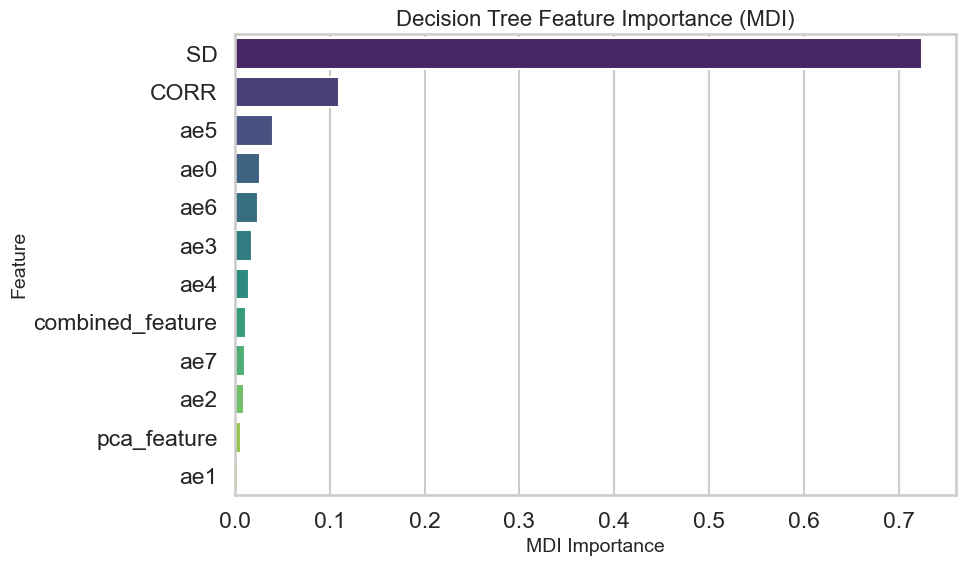

In [10]:
# MDI+ 
import seaborn as sns
import matplotlib.pyplot as plt

mdi_importances = dt_pipeline.named_steps['clf'].feature_importances_

importances_df_mdi = pd.DataFrame({
    'feature': X.columns,
    'mdi_importance': mdi_importances
}).sort_values('mdi_importance', ascending=False)

print("\nMDI Feature Importances:")
sns.set_theme(style="whitegrid", context="talk")

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=importances_df_mdi, x='mdi_importance', y='feature', ax=ax, palette='viridis')
ax.set_title('Decision Tree Feature Importance (MDI)', fontsize=16)
ax.set_xlabel('MDI Importance', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
from sklearn.neural_network import MLPClassifier

# Neural Network model
nn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, random_state=42))
])

# Cross-validate the Neural Network.
nn_acc, nn_auc = evaluate_model(nn_pipeline, X_train, y_train, cv)
print(f"Neural Network CV: Accuracy = {nn_acc:.3f}, ROC AUC = {nn_auc:.3f}")

# Fit the MLP on the training set and evaluate on the validation set.
nn_pipeline.fit(X_train, y_train)
y_val_pred = nn_pipeline.predict(X_val)
if hasattr(nn_pipeline, "predict_proba"):
    y_val_score = nn_pipeline.predict_proba(X_val)[:, 1]
else:
    y_val_score = nn_pipeline.decision_function(X_val)
print("Neural Network on Validation Set: Accuracy =", accuracy_score(y_val, y_val_pred),
      "ROC AUC =", roc_auc_score(y_val, y_val_score))



Neural Network CV: Accuracy = 0.989, ROC AUC = 0.999
Neural Network on Validation Set: Accuracy = 0.9890937981510015 ROC AUC = 0.9993408681515555


In [12]:
# Permuation Importance for NN

nn_perm = permutation_importance(nn_pipeline, X_val, y_val, n_repeats=10, random_state=313, n_jobs=-1)
importances_df_nn = pd.DataFrame({
    'feature': X.columns,
    'mean_importance': nn_perm['importances_mean'],
    'std_importance': nn_perm['importances_std']
}).sort_values('mean_importance', ascending=False)
print(importances_df_nn)


             feature  mean_importance  std_importance
0                ae0         0.185442        0.002063
5                ae5         0.082454        0.001209
11  combined_feature         0.054343        0.001235
2                ae2         0.043825        0.000618
4                ae4         0.039248        0.000907
3                ae3         0.029675        0.000499
7                ae7         0.028202        0.000829
10       pca_feature         0.027634        0.000609
8                 SD         0.027083        0.000663
6                ae6         0.025701        0.000658
1                ae1         0.016097        0.000799
9               CORR         0.013172        0.000457


AE5 and AE0 are two of the most important features in the dataset across all the models we have.

                 Model  Precision    Recall  F1-score  Accuracy
0  Logistic Regression   0.968118  0.967971  0.967981  0.967971
1        Decision Tree   0.924339  0.924321  0.924299  0.924321
2       Neural Network   0.969822  0.967813  0.967825  0.967813


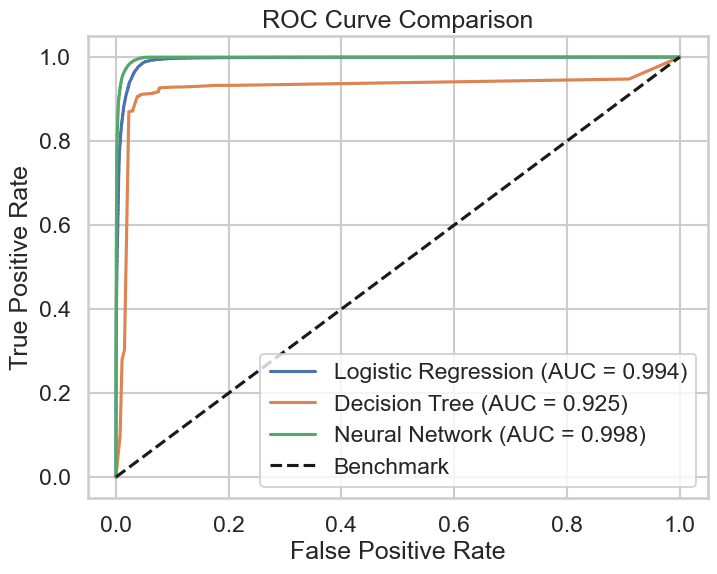

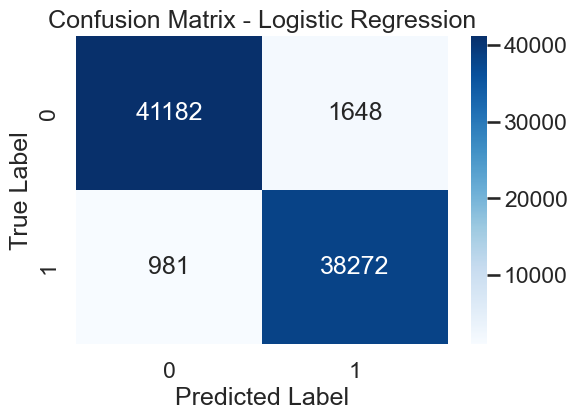

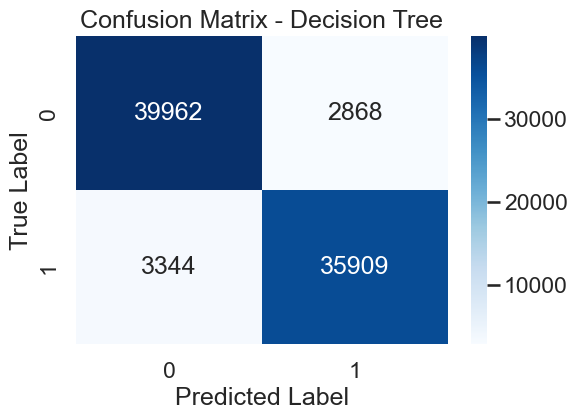

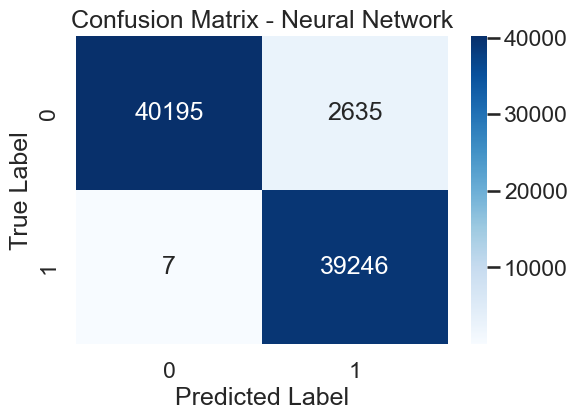

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict_proba(X_test)[:, 1]

dt_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5, random_state=200)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict_proba(X_test)[:, 1]

nn_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=788)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)

auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)
auc_nn = auc(fpr_nn, tpr_nn)

y_pred_lr_bi = (y_pred_lr > 0.5).astype(int)
y_pred_dt_bi = (y_pred_dt > 0.5).astype(int)
y_pred_nn_bi = (y_pred_nn > 0.5).astype(int)

report_lr = classification_report(y_test, y_pred_lr_bi, output_dict=True)
report_dt = classification_report(y_test, y_pred_dt_bi, output_dict=True)
report_nn = classification_report(y_test, y_pred_nn_bi, output_dict=True)

conf_matrix_lr = confusion_matrix(y_test, y_pred_lr_bi)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt_bi)
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn_bi)

classification_reports_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Neural Network"],
    "Precision": [report_lr["weighted avg"]["precision"], report_dt["weighted avg"]["precision"], report_nn["weighted avg"]["precision"]],
    "Recall": [report_lr["weighted avg"]["recall"], report_dt["weighted avg"]["recall"], report_nn["weighted avg"]["recall"]],
    "F1-score": [report_lr["weighted avg"]["f1-score"], report_dt["weighted avg"]["f1-score"], report_nn["weighted avg"]["f1-score"]],
    "Accuracy": [report_lr["accuracy"], report_dt["accuracy"], report_nn["accuracy"]]
})

print(classification_reports_df)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.3f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Benchmark')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


plot_confusion_matrix(y_test, y_pred_lr_bi, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_dt_bi, "Decision Tree")
plot_confusion_matrix(y_test, y_pred_nn_bi, "Neural Network")

## Use a different approach to seperate the training, validation and test data

Leave-one-image-out cross-validation is used to evaluate the model performance. The model is trained on n-1 observations and tested on the remaining observation. Since we have only 3 plots, we can use this method to evaluate the model performance.

In [49]:
csv_files = [
    "dataset\\O012791_merged.csv",
    "dataset\\O013257_merged.csv",
    "dataset\\O013490_merged.csv"
] 

for file in csv_files:
    df = pd.read_csv(file)
    df = df[df["Label"] != 0]
    cols = [col for col in df.columns if col != "Label"] + ["Label"]
    df = df[cols]
    df = df.drop(columns=["patch_entropy", "x", "y"], errors='ignore')
    output_file = f"{file.replace('_merged.csv', '_modified.csv').split('/')[-1]}"  
    df.to_csv(output_file, index=False)
    print(f"Modified data saved to {output_file}")


Modified data saved to dataset\O012791_modified.csv
Modified data saved to dataset\O013257_modified.csv
Modified data saved to dataset\O013490_modified.csv


In [60]:
train_val_files = [
    "C:/Users/lenovo/Desktop/stats214/lab2wzh/dataset/O012791_modified.csv",
    "C:/Users/lenovo/Desktop/stats214/lab2wzh/dataset/O013257_modified.csv"
]
test_file = "C:/Users/lenovo/Desktop/stats214/lab2wzh/dataset/O013490_modified.csv"

# We use the first two datasets for training and validation
# The third dataset is used for testing
train_val_df = pd.concat([pd.read_csv(file) for file in train_val_files], ignore_index=True)
test_df = pd.read_csv(test_file)

train_val_df = train_val_df.drop(columns=['NDAI'])
test_df = test_df.drop(columns=['NDAI'])

cols_to_scale = ['grad_mean', 'patch_range']
scaler = StandardScaler()
pca = PCA(n_components=1)

train_val_df[cols_to_scale] = scaler.fit_transform(train_val_df[cols_to_scale])
test_df[cols_to_scale] = scaler.transform(test_df[cols_to_scale])  

train_val_df['combined_feature'] = pca.fit_transform(train_val_df[cols_to_scale])
test_df['combined_feature'] = pca.transform(test_df[cols_to_scale])

train_val_df = train_val_df.drop(columns=cols_to_scale)
test_df = test_df.drop(columns=cols_to_scale)

X = train_val_df.drop('Label', axis=1)
y = train_val_df['Label'].map({-1.0: 0, 1.0: 1}) 

# 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test = test_df.drop('Label', axis=1)
y_test = test_df['Label'].map({-1.0: 0, 1.0: 1})

def evaluate_model(model, X, y, cv):
    scoring = ['accuracy', 'roc_auc']
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return np.mean(scores['test_accuracy']), np.mean(scores['test_roc_auc'])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
lr_pipeline = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(solver='lbfgs', max_iter=500, random_state=635))])

lr_acc, lr_auc = evaluate_model(lr_pipeline, X_train, y_train, cv)
print(f"Logistic Regression: Accuracy = {lr_acc:.3f}, ROC AUC = {lr_auc:.3f}")
X_train_sm = sm.add_constant(StandardScaler().fit_transform(X_train))
lr_model_sm = sm.Logit(y_train, X_train_sm).fit(disp=0)
print("Logistic Regression AIC:", lr_model_sm.aic)

print('Coefficients:')
print(lr_model_sm.params)

lr_pipeline.fit(X_train, y_train)
lr_perm = permutation_importance(lr_pipeline, X_val, y_val, n_repeats=10, random_state=313, n_jobs=-1)
importances_df_lr = pd.DataFrame({
    'feature': X.columns,
    'mean_importance': lr_perm['importances_mean'],
    'std_importance': lr_perm['importances_std']
}).sort_values('mean_importance', ascending=False)

print(importances_df_lr)



Logistic Regression: Accuracy = 0.933, ROC AUC = 0.965
Logistic Regression AIC: 44764.10574482271
Coefficients:
const   -1.247203
x1       1.044568
x2       0.558694
x3      -0.696419
x4      -1.322932
x5       0.711227
x6       1.422819
x7      -0.842678
x8      -0.424743
x9      -0.024076
x10      0.554631
x11     -1.629790
x12      0.769225
dtype: float64
             feature  mean_importance  std_importance
10       pca_feature         0.153519        0.001769
5                ae5         0.055725        0.000854
3                ae3         0.044092        0.001117
0                ae0         0.041676        0.001263
6                ae6         0.025975        0.000486
11  combined_feature         0.019697        0.000827
4                ae4         0.014244        0.000901
1                ae1         0.009976        0.000607
2                ae2         0.007448        0.000651
7                ae7         0.007042        0.000731
9               CORR         0.006576        

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

# Select a few hyperparameters
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5]}

# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=2001)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state= 918)

# Setup GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
    )

grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
print("Best ROC AUC score from CV:", grid_search.best_score_)

# Evaluate the best model
best_dt_model = grid_search.best_estimator_
y_val_pred = best_dt_model.predict(X_val)
y_val_score = best_dt_model.predict_proba(X_val)[:, 1]
val_acc = accuracy_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_score)
print("Best Decision Tree on Validation Set: Accuracy =", val_acc, ", ROC AUC =", val_auc)

Fitting 100 folds for each of 12 candidates, totalling 1200 fits
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}
Best ROC AUC score from CV: 0.9857450415492672
Best Decision Tree on Validation Set: Accuracy = 0.9607484076433122 , ROC AUC = 0.984607114851499


                 Model  Precision    Recall  F1-score  Accuracy
0  Logistic Regression   0.960431  0.960260  0.960272  0.960260
1        Decision Tree   0.954748  0.952451  0.952465  0.952451
2       Neural Network   0.947968  0.947882  0.947893  0.947882


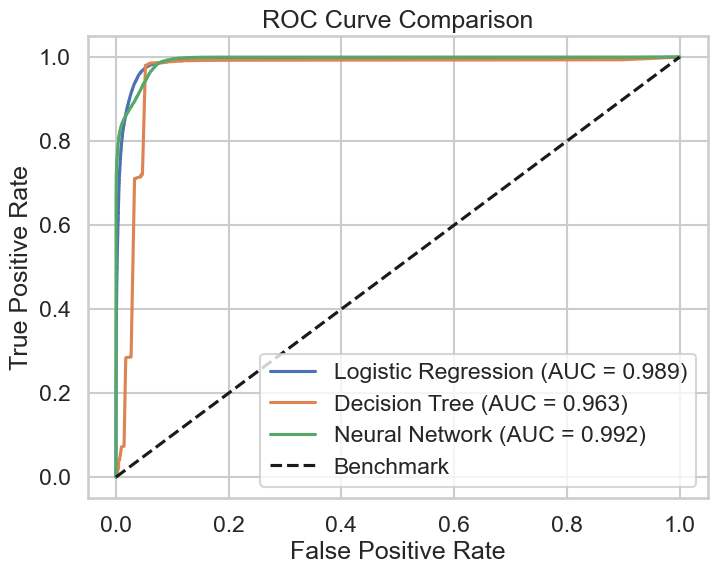

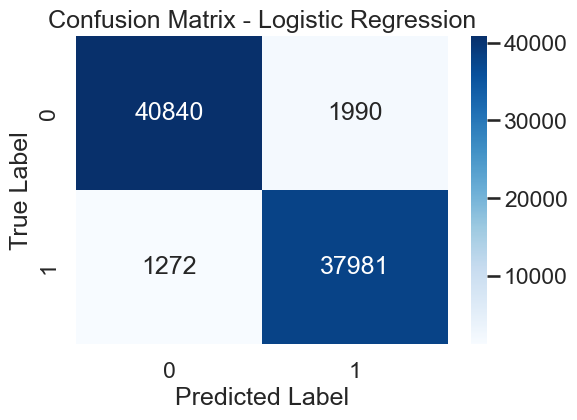

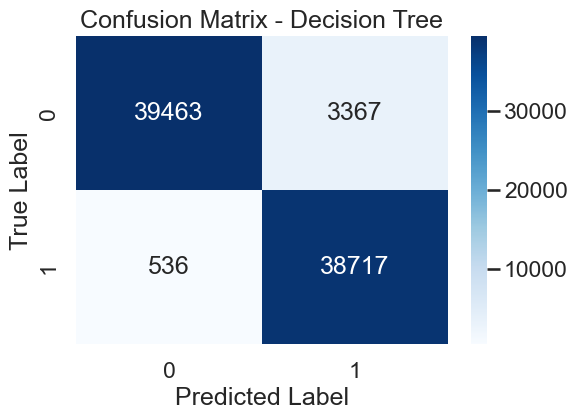

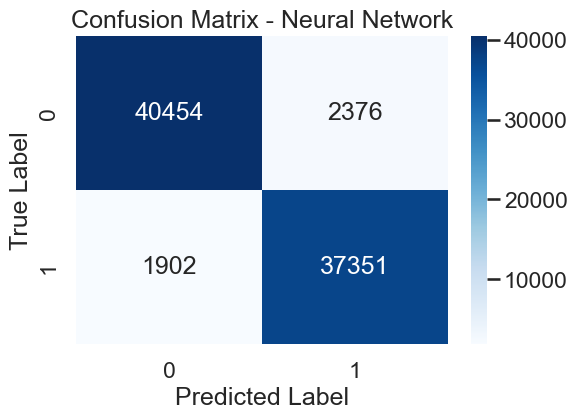

In [62]:
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict_proba(X_test)[:, 1]

dt_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5, random_state=200)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict_proba(X_test)[:, 1]

nn_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=788)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)

auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)
auc_nn = auc(fpr_nn, tpr_nn)

y_pred_lr_bi = (y_pred_lr > 0.5).astype(int)
y_pred_dt_bi = (y_pred_dt > 0.5).astype(int)
y_pred_nn_bi = (y_pred_nn > 0.5).astype(int)

report_lr = classification_report(y_test, y_pred_lr_bi, output_dict=True)
report_dt = classification_report(y_test, y_pred_dt_bi, output_dict=True)
report_nn = classification_report(y_test, y_pred_nn_bi, output_dict=True)

conf_matrix_lr = confusion_matrix(y_test, y_pred_lr_bi)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt_bi)
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn_bi)

classification_reports_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Neural Network"],
    "Precision": [report_lr["weighted avg"]["precision"], report_dt["weighted avg"]["precision"], report_nn["weighted avg"]["precision"]],
    "Recall": [report_lr["weighted avg"]["recall"], report_dt["weighted avg"]["recall"], report_nn["weighted avg"]["recall"]],
    "F1-score": [report_lr["weighted avg"]["f1-score"], report_dt["weighted avg"]["f1-score"], report_nn["weighted avg"]["f1-score"]],
    "Accuracy": [report_lr["accuracy"], report_dt["accuracy"], report_nn["accuracy"]]
})

print(classification_reports_df)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.3f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Benchmark')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


plot_confusion_matrix(y_test, y_pred_lr_bi, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_dt_bi, "Decision Tree")
plot_confusion_matrix(y_test, y_pred_nn_bi, "Neural Network")

In [63]:
lr_l2_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500, random_state=635))
])

param_grid = {'clf__C': [1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5, 1e6]}  

grid_search = GridSearchCV(lr_l2_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Optimal lambda = {1/grid_search.best_params_['clf__C']:.4f}")
print(f"Optimal AUC = {grid_search.best_score_:.4f}")

best_lr_model = grid_search.best_estimator_
y_pred_lr_best = best_lr_model.predict_proba(X_test)[:, 1]

fpr_lr_best, tpr_lr_best, _ = roc_curve(y_test, y_pred_lr_best)
auc_lr_best = auc(fpr_lr_best, tpr_lr_best)
y_pred_lr_best_bi = best_lr_model.predict(X_test)

report_lr_best = classification_report(y_test, y_pred_lr_best_bi, output_dict=True)
conf_matrix_lr_best = confusion_matrix(y_test, y_pred_lr_best_bi)

print(f"Best Logistic Regression: AUC = {auc_lr_best:.3f}")
print("Classification Report:")
print(classification_reports_df)

Optimal lambda = 100.0000
Optimal AUC = 0.9656
Best Logistic Regression: AUC = 0.989
Classification Report:
                 Model  Precision    Recall  F1-score  Accuracy
0  Logistic Regression   0.960431  0.960260  0.960272  0.960260
1        Decision Tree   0.954748  0.952451  0.952465  0.952451
2       Neural Network   0.947968  0.947882  0.947893  0.947882


In [64]:
from sklearn.feature_selection import SequentialFeatureSelector

base_lr = LogisticRegression(penalty='l2', C=grid_search.best_params_['clf__C'], solver='lbfgs', max_iter=500, random_state=635)
sfs = SequentialFeatureSelector(base_lr, n_features_to_select=8, direction="backward", cv=10, scoring="roc_auc", n_jobs=-1)
sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(f" Selected features: {list(selected_features)}")

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
base_lr.fit(X_train_selected, y_train)
y_pred_lr_selected = base_lr.predict_proba(X_test_selected)[:, 1]

fpr_lr_selected, tpr_lr_selected, _ = roc_curve(y_test, y_pred_lr_selected)
auc_lr_selected = auc(fpr_lr_selected, tpr_lr_selected)

y_pred_lr_selected_bi = base_lr.predict(X_test_selected)
report_lr_selected = classification_report(y_test, y_pred_lr_selected_bi, output_dict=True)

print(f"Selected Logistic Regression: AUC = {auc_lr_selected:.3f}")
print("Classification Report:")
report_lr_selected


 Selected features: ['ae2', 'ae3', 'ae4', 'ae5', 'ae6', 'CORR', 'pca_feature', 'combined_feature']
Selected Logistic Regression: AUC = 0.983
Classification Report:


{'0': {'precision': 0.9011136543709833,
  'recall': 0.9559420966612188,
  'f1-score': 0.9277184872997529,
  'support': 42830},
 '1': {'precision': 0.9485087455999127,
  'recall': 0.8855374111532877,
  'f1-score': 0.9159420289855071,
  'support': 39253},
 'accuracy': 0.9222737960357199,
 'macro avg': {'precision': 0.924811199985448,
  'recall': 0.9207397539072533,
  'f1-score': 0.9218302581426301,
  'support': 82083},
 'weighted avg': {'precision': 0.9237785120882838,
  'recall': 0.9222737960357199,
  'f1-score': 0.9220868544621484,
  'support': 82083}}

In [65]:
csv_files = [
    "dataset\\O012791_merged.csv",
    "dataset\\O013257_merged.csv",
    "dataset\\O013490_merged.csv"
] 

for file in csv_files:
    df = pd.read_csv(file)
    df = df[df["Label"] != 0]
    cols = [col for col in df.columns if col != "Label"] + ["Label"]
    df = df[cols]
    df = df.drop(columns=["patch_entropy"], errors='ignore')
    output_file = f"{file.replace('_merged.csv', '_modified_withxy.csv').split('/')[-1]}"  
    df.to_csv(output_file, index=False)
    print(f"Modified data saved to {output_file}")


Modified data saved to dataset\O012791_modified_withxy.csv
Modified data saved to dataset\O013257_modified_withxy.csv
Modified data saved to dataset\O013490_modified_withxy.csv


In [88]:
train_val_files = [
    "C:/Users/lenovo/Desktop/stats214/lab2wzh/dataset/O012791_modified_withxy.csv",
    "C:/Users/lenovo/Desktop/stats214/lab2wzh/dataset/O013257_modified_withxy.csv"
]
test_file = "C:/Users/lenovo/Desktop/stats214/lab2wzh/dataset/O013490_modified_withxy.csv"

train_val_df = pd.concat([pd.read_csv(file) for file in train_val_files], ignore_index=True)
test_df = pd.read_csv(test_file)

train_val_xy = train_val_df[['x', 'y']].copy()
test_xy = test_df[['x', 'y']].copy()

# Delete the NDAI column
train_val_df = train_val_df.drop(columns=['NDAI'])
test_df = test_df.drop(columns=['NDAI'])

# 
cols_to_scale = ['grad_mean', 'patch_range']
scaler = StandardScaler()
pca = PCA(n_components=1)

train_val_df[cols_to_scale] = scaler.fit_transform(train_val_df[cols_to_scale])
test_df[cols_to_scale] = scaler.transform(test_df[cols_to_scale])

train_val_df['combined_feature'] = pca.fit_transform(train_val_df[cols_to_scale])
test_df['combined_feature'] = pca.transform(test_df[cols_to_scale])

train_val_df = train_val_df.drop(columns=cols_to_scale)
test_df = test_df.drop(columns=cols_to_scale)

# Map labels from {-1, 1} to {0, 1} No cloud = 0, Cloud = 1
X = train_val_df.drop(['Label'], axis=1)
y = train_val_df['Label'].map({-1.0: 0, 1.0: 1})

X_train, X_val, y_train, y_val, train_xy, val_xy = train_test_split(
    X, y, train_val_xy, test_size=0.2, random_state=42, stratify=y
)

X_test = test_df.drop(['Label'], axis=1)
y_test = test_df['Label'].map({-1.0: 0, 1.0: 1})
test_xy = test_xy.reset_index(drop=True)


In [97]:
lr_l2_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500, random_state=635))
])

param_grid = {'clf__C': [1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5, 1e6]}  

grid_search = GridSearchCV(lr_l2_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Optimal lambda = {1/grid_search.best_params_['clf__C']:.4f}")
print(f"Optimal AUC = {grid_search.best_score_:.4f}")

best_lr_model = grid_search.best_estimator_
y_pred_lr_best = best_lr_model.predict_proba(X_test)[:, 1]

fpr_lr_best, tpr_lr_best, _ = roc_curve(y_test, y_pred_lr_best)
auc_lr_best = auc(fpr_lr_best, tpr_lr_best)
y_pred_lr_best_bi = best_lr_model.predict(X_test)

report_lr_best = classification_report(y_test, y_pred_lr_best_bi, output_dict=True)
conf_matrix_lr_best = confusion_matrix(y_test, y_pred_lr_best_bi)

misclassified_idx = np.where(y_test != y_pred_lr_best_bi)[0]
X_misclassified = X_test.iloc[misclassified_idx]
y_misclassified = y_test.iloc[misclassified_idx]

Optimal lambda = 0.1000
Optimal AUC = 0.9706


Misclassified true label 0:
          x      y  count
0      78.0  370.0      1
1      79.0  369.0      1
2      79.0  370.0      1
3      80.0  341.0      1
4      80.0  342.0      1
...     ...    ...    ...
1230  367.0   25.0      1
1231  367.0   26.0      1
1232  368.0  320.0      1
1233  368.0  321.0      1
1234  368.0  322.0      1

[1235 rows x 3 columns]
(1235, 3)

Misclassified true label 1:
         x      y  count
0     66.0  288.0      1
1     66.0  289.0      1
2     66.0  290.0      1
3     66.0  291.0      1
4     66.0  292.0      1
..     ...    ...    ...
902  366.0   77.0      1
903  366.0   78.0      1
904  366.0   79.0      1
905  367.0   78.0      1
906  367.0   79.0      1

[907 rows x 3 columns]
(907, 3)
Misclassified true label 0 satisfying condition: 265
Misclassified true label 1 satisfying condition: 305


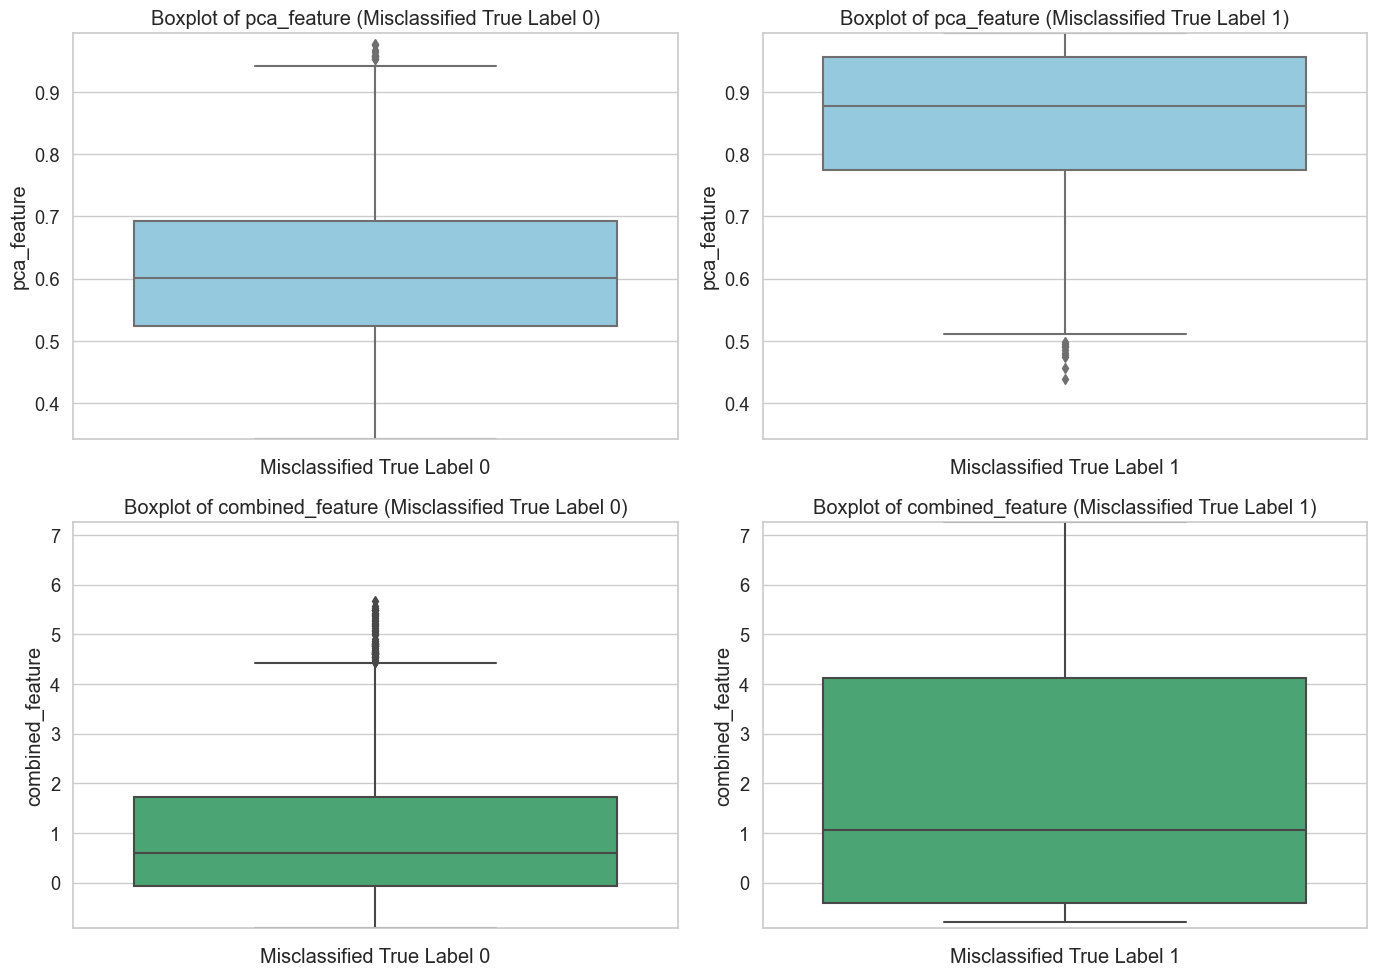

In [109]:
misclassified_df = test_xy.iloc[misclassified_idx].copy()
misclassified_df['true_label'] = y_test.iloc[misclassified_idx].values

misclassified_0 = misclassified_df[misclassified_df['true_label'] == 0].groupby(['x', 'y']).size().reset_index(name='count')
print("Misclassified true label 0:")
print(misclassified_0)
print(misclassified_0.shape)

misclassified_1 = misclassified_df[misclassified_df['true_label'] == 1].groupby(['x', 'y']).size().reset_index(name='count')
print("\nMisclassified true label 1:")
print(misclassified_1)
print(misclassified_1.shape)

# Interested in the edge cases where the misclassified patches are located (patch_size = 9)
# X: [70,368], Y: [2,383]
# We consider when the patch is not fully within the image
condition_0 = (misclassified_0['x'] < 79) | (misclassified_0['x'] > 359) | (misclassified_0['y'] < 11) | (misclassified_0['y'] > 374)
count_misclassified_0 = misclassified_0.loc[condition_0, 'count'].sum()

condition_1 = (misclassified_1['x'] < 79) | (misclassified_1['x'] > 359) | (misclassified_1['y'] < 11) | (misclassified_1['y'] > 374)
count_misclassified_1 = misclassified_1.loc[condition_1, 'count'].sum()

print("Misclassified true label 0 satisfying condition:", count_misclassified_0)
print("Misclassified true label 1 satisfying condition:", count_misclassified_1)

misclassified_df = X_test.iloc[misclassified_idx].copy()
misclassified_df['true_label'] = y_test.iloc[misclassified_idx].values

X_misclassified_0 = misclassified_df[misclassified_df['true_label'] == 0]
X_misclassified_1 = misclassified_df[misclassified_df['true_label'] == 1]

pca_min = min(X_misclassified_0['pca_feature'].min(), X_misclassified_1['pca_feature'].min())
pca_max = max(X_misclassified_0['pca_feature'].max(), X_misclassified_1['pca_feature'].max())

combined_min = min(X_misclassified_0['combined_feature'].min(), X_misclassified_1['combined_feature'].min())
combined_max = max(X_misclassified_0['combined_feature'].max(), X_misclassified_1['combined_feature'].max())

sns.set_theme(style="whitegrid", font_scale=1.2)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(y=X_misclassified_0['pca_feature'], color='skyblue', ax=axs[0, 0])
axs[0, 0].set_title("Boxplot of pca_feature (Misclassified True Label 0)")
axs[0, 0].set_xlabel("Misclassified True Label 0")  
axs[0, 0].set_ylabel("pca_feature")
axs[0, 0].set_ylim(pca_min, pca_max)

sns.boxplot(y=X_misclassified_1['pca_feature'], color='skyblue', ax=axs[0, 1])
axs[0, 1].set_title("Boxplot of pca_feature (Misclassified True Label 1)")
axs[0, 1].set_xlabel("Misclassified True Label 1") 
axs[0, 1].set_ylabel("pca_feature")
axs[0, 1].set_ylim(pca_min, pca_max)

sns.boxplot(y=X_misclassified_0['combined_feature'], color='mediumseagreen', ax=axs[1, 0])
axs[1, 0].set_title("Boxplot of combined_feature (Misclassified True Label 0)")
axs[1, 0].set_xlabel("Misclassified True Label 0")
axs[1, 0].set_ylabel("combined_feature")
axs[1, 0].set_ylim(combined_min, combined_max)

sns.boxplot(y=X_misclassified_1['combined_feature'], color='mediumseagreen', ax=axs[1, 1])
axs[1, 1].set_title("Boxplot of combined_feature (Misclassified True Label 1)")
axs[1, 1].set_xlabel("Misclassified True Label 1")  
axs[1, 1].set_ylabel("combined_feature")
axs[1, 1].set_ylim(combined_min, combined_max)

plt.tight_layout()
plt.savefig("publication_quality_boxplots.png")
plt.show()

